In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import random
from sklearn.mixture import GaussianMixture
from tqdm.auto import tqdm
from collections import Counter

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sentence_transformers import SentenceTransformer
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud



print("done")

done
The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


# Load Dataset
first load in the data set

In [62]:
pd.set_option('display.max_colwidth', 100)
train_df = pd.read_csv('/kaggle/input/ethz-cil-text-classification-2025/data/training.csv')
test_df = pd.read_csv('/kaggle/input/ethz-cil-text-classification-2025/data/test.csv')

print(f"Training set shape: {train_df.shape}")
print(f"Test set shape: {test_df.shape}")


Training set shape: (102097, 3)
Test set shape: (11951, 2)


# Analyze le data
###  baisc analysis

#missing values:
id          0
sentence    0
label       0
dtype: int64
label distro:


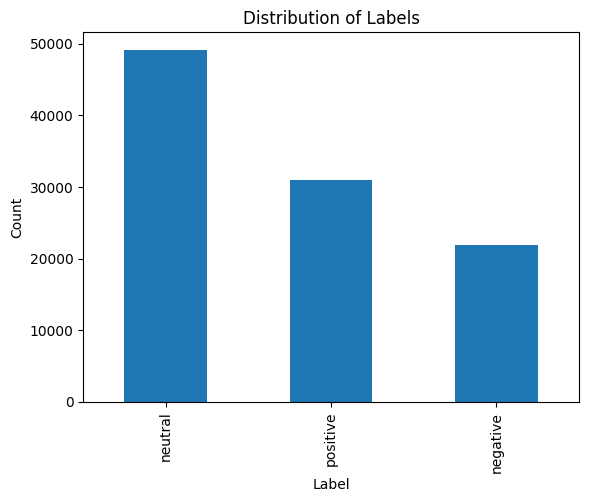

In [63]:
print("#missing values:")
print(train_df.isnull().sum())

print("label distro:")
label_counts = train_df['label'].value_counts()
label_counts.plot(kind='bar')
plt.title('Distribution of Labels')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

In [64]:
import re
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def clean_text(text):

    text = text.lower()

    text = text.replace('"', '').replace('\'', '').replace('.', '').replace(',', '')
    text = re.sub(r'Û', '', text)

    text = re.sub(r'\s+', ' ', text).strip()

    tokens = text.split()

    tokens = [word for word in tokens if word not in stop_words]

    return ' '.join(tokens)

train_df['cleaned_sentence'] = train_df['sentence'].apply(clean_text)
test_df['cleaned_sentence'] = test_df['sentence'].apply(clean_text)

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# K-clustering & GMM

In [65]:
# 1. Create Sentence Transformer embeddings
def sentence_transformer_embeddings(texts):
    """Create embeddings using Sentence Transformer"""
    print("Creating Sentence Transformer embeddings...")
    # all-MiniLM-L6-v2 is fast and works well for short texts
    model = SentenceTransformer('all-MiniLM-L6-v2')
    embeddings = model.encode(texts, show_progress_bar=True)
    print(f"Sentence Transformer embeddings shape: {embeddings.shape}")
    return embeddings

# 2. Dimensionality Reduction
def reduce_dimensions(embeddings, n_components=2, method='pca'):
    """Reduce dimensionality of embeddings for visualization"""
    print(f"Reducing dimensions using {method.upper()}...")
    if method == 'pca':
        reducer = PCA(n_components=n_components, random_state=21)
    
    reduced_embeddings = reducer.fit_transform(embeddings)
    return reduced_embeddings

# 3A. K-Means Clustering
def kmeans_clustering(embeddings, n_clusters=5):
    """Perform K-means clustering"""
    print(f"Performing K-means clustering with {n_clusters} clusters...")
    kmeans = KMeans(
        n_clusters=n_clusters,
        random_state=42,
        n_init=10
    )
    cluster_labels = kmeans.fit_predict(embeddings)
    silhouette = silhouette_score(embeddings, cluster_labels)
    print(f"K-means Silhouette Score: {silhouette:.4f}")
    return cluster_labels, kmeans

# 3B. GMM Clustering
def gmm_clustering(embeddings, n_components=5):
    """Perform Gaussian Mixture Model clustering"""
    print(f"Performing GMM clustering with {n_components} components...")
    gmm = GaussianMixture(
        n_components=n_components,
        random_state=42,
        covariance_type='full',
        max_iter=100
    )
    cluster_labels = gmm.fit_predict(embeddings)
    
    # Calculate metrics
    silhouette = silhouette_score(embeddings, cluster_labels)
    bic_score = gmm.bic(embeddings)
    aic_score = gmm.aic(embeddings)
    
    print(f"GMM Silhouette Score: {silhouette:.4f}")
    print(f"GMM BIC Score: {bic_score:.2f}")
    print(f"GMM AIC Score: {aic_score:.2f}")
    
    return cluster_labels, gmm

# 4. Evaluation and Visualization

def plot_clusters(reduced_embeddings, labels, title="Cluster Visualization"):
    """Plot the clusters in 2D space"""
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(
        reduced_embeddings[:, 0],
        reduced_embeddings[:, 1],
        c=labels,
        cmap='tab10',
        alpha=0.7,
        s=10
    )
    plt.colorbar(scatter)
    plt.title(title)
    plt.xlabel("Dimension 1")
    plt.ylabel("Dimension 2")
    plt.tight_layout()
    plt.show()

def compare_clusters(reduced_embeddings, kmeans_labels, gmm_labels, gmm_probs=None):
    """Compare K-means and GMM clustering results"""
    fig, axes = plt.subplots(1, 2, figsize=(18, 8))
    
    # K-means plot (hard clustering)
    scatter1 = axes[0].scatter(
        reduced_embeddings[:, 0],
        reduced_embeddings[:, 1],
        c=kmeans_labels,
        cmap='tab10',
        alpha=0.7,
        s=20
    )
    axes[0].set_title("K-means Clustering (Hard Assignment)")
    axes[0].set_xlabel("Dimension 1")
    axes[0].set_ylabel("Dimension 2")
    
    # GMM plot - if probabilities provided, show uncertainty
    if gmm_probs is not None:
        max_probs = np.max(gmm_probs, axis=1)
        scatter2 = axes[1].scatter(
            reduced_embeddings[:, 0],
            reduced_embeddings[:, 1],
            c=gmm_labels,
            cmap='tab10',
            alpha=max_probs,  # Transparency shows confidence
            s=20
        )
        axes[1].set_title("GMM Clustering (transparency = confidence)")
    else:
        scatter2 = axes[1].scatter(
            reduced_embeddings[:, 0],
            reduced_embeddings[:, 1],
            c=gmm_labels,
            cmap='tab10',
            alpha=0.7,
            s=20
        )
        axes[1].set_title("GMM Clustering (Hard Assignment)")
    
    axes[1].set_xlabel("Dimension 1")
    axes[1].set_ylabel("Dimension 2")
    
    plt.tight_layout()
    plt.show()

def get_top_words_per_cluster(texts, labels, n_clusters, top_n=10):
    """Get the most common words for each cluster"""
    cluster_words = {i: [] for i in range(n_clusters)}
    for text, label in zip(texts, labels):
        words = re.findall(r'\b\w+\b', text.lower())
        words = [w for w in words if w not in stopwords.words('english') and len(w) > 2]
        cluster_words[label].extend(words)
    
    top_words = {}
    for cluster, words in cluster_words.items():
        word_counts = Counter(words)
        top_words[cluster] = word_counts.most_common(top_n)
    
    return top_words

def generate_wordclouds(texts, labels, n_clusters, title="Word Clouds by Cluster"):
    """Generate word clouds for each cluster"""
    cluster_texts = {i: [] for i in range(n_clusters)}
    for text, label in zip(texts, labels):
        cluster_texts[label].append(text)
    
    fig, axes = plt.subplots(2, (n_clusters + 1) // 2, figsize=(20, 10))
    axes = axes.flatten()
    
    for i in range(n_clusters):
        combined_text = " ".join(cluster_texts[i])
        wordcloud = WordCloud(
            background_color="white",
            max_words=100,
            contour_width=3,
            contour_color='steelblue',
            width=800,
            height=400
        ).generate(combined_text)
        
        axes[i].imshow(wordcloud, interpolation='bilinear')
        axes[i].set_title(f'Cluster {i} ({len(cluster_texts[i])} reviews)')
        axes[i].axis("off")
    
    # Handle any empty subplots
    for i in range(n_clusters, len(axes)):
        fig.delaxes(axes[i])
    
    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

def plot_gmm_probabilities(reduced_embeddings, gmm_probs, title="GMM Soft Clustering"):
    """Plot GMM results showing probability distributions as mixed colors"""
    fig, axes = plt.subplots(1, 3, figsize=(24, 8))
    
    # Define colors for each component
    colors = plt.cm.tab10(np.linspace(0, 1, gmm_probs.shape[1]))
    
    # Plot 1: Hard assignment (most likely cluster)
    hard_labels = np.argmax(gmm_probs, axis=1)
    scatter1 = axes[0].scatter(
        reduced_embeddings[:, 0],
        reduced_embeddings[:, 1],
        c=hard_labels,
        cmap='tab10',
        alpha=0.7,
        s=20
    )
    axes[0].set_title("GMM - Hard Assignment")
    axes[0].set_xlabel("Dimension 1")
    axes[0].set_ylabel("Dimension 2")
    
    # Plot 2: Color mixing based on probabilities
    mixed_colors = np.dot(gmm_probs, colors[:, :3])  # Mix RGB values
    scatter2 = axes[1].scatter(
        reduced_embeddings[:, 0],
        reduced_embeddings[:, 1],
        c=mixed_colors,
        alpha=0.7,
        s=20
    )
    axes[1].set_title("GMM - Probability Color Mixing")
    axes[1].set_xlabel("Dimension 1")
    axes[1].set_ylabel("Dimension 2")
    
    # Plot 3: Confidence visualization (alpha based on max probability)
    max_probs = np.max(gmm_probs, axis=1)
    scatter3 = axes[2].scatter(
        reduced_embeddings[:, 0],
        reduced_embeddings[:, 1],
        c=hard_labels,
        cmap='tab10',
        alpha=max_probs,  # More transparent = less confident
        s=20
    )
    axes[2].set_title("GMM - Confidence (transparency = uncertainty)")
    axes[2].set_xlabel("Dimension 1")
    axes[2].set_ylabel("Dimension 2")
    
    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

def find_optimal_clusters(embeddings, max_clusters=10):
    """Find the optimal number of clusters using multiple metrics"""
    bic_scores = []
    aic_scores = []
    silhouette_scores_kmeans = []
    silhouette_scores_gmm = []
    
    for n_clusters in range(2, max_clusters + 1):
        print(f"Testing {n_clusters} clusters...")
        
        # K-means
        kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
        kmeans_labels = kmeans.fit_predict(embeddings)
        silhouette_kmeans = silhouette_score(embeddings, kmeans_labels)
        silhouette_scores_kmeans.append(silhouette_kmeans)
        
        # GMM
        gmm = GaussianMixture(n_components=n_clusters, random_state=42, covariance_type='full')
        gmm_labels = gmm.fit_predict(embeddings)
        silhouette_gmm = silhouette_score(embeddings, gmm_labels)
        bic_score = gmm.bic(embeddings)
        aic_score = gmm.aic(embeddings)
        
        silhouette_scores_gmm.append(silhouette_gmm)
        bic_scores.append(bic_score)
        aic_scores.append(aic_score)

    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # Plot BIC and AIC Scores
    axes[0].plot(range(2, max_clusters + 1), bic_scores, marker='o', label='BIC')
    axes[0].plot(range(2, max_clusters + 1), aic_scores, marker='s', label='AIC')
    axes[0].set_title('Information Criteria vs Number of Clusters (GMM)')
    axes[0].set_xlabel('Number of clusters')
    axes[0].set_ylabel('Score (lower is better)')
    axes[0].legend()
    axes[0].grid(True)
    
    # Plot Silhouette Scores
    #axes[1].plot(range(2, max_clusters + 1), silhouette_scores_kmeans, marker='x', label='K-means')
    axes[1].plot(range(2, max_clusters + 1), silhouette_scores_gmm, marker='o', label='GMM')
    axes[1].set_title('Silhouette Score vs Number of Clusters')
    axes[1].set_xlabel('Number of clusters')
    axes[1].set_ylabel('Silhouette Score (higher is better)')
    #axes[1].legend()
    axes[1].grid(True)
    
    # Plot difference in silhouette scores
    silhouette_diff = np.array(silhouette_scores_gmm) - np.array(silhouette_scores_kmeans)
    axes[2].plot(range(2, max_clusters + 1), silhouette_diff, marker='d', color='purple')
    axes[2].axhline(y=0, color='black', linestyle='--', alpha=0.5)
    axes[2].set_title('GMM vs K-means Silhouette Score Difference')
    axes[2].set_xlabel('Number of clusters')
    axes[2].set_ylabel('GMM - K-means Silhouette Score')
    axes[2].grid(True)
    
    plt.tight_layout()
    plt.show()
    
    # Determine optimal number of clusters
    best_kmeans_idx = np.argmax(silhouette_scores_kmeans)
    best_gmm_idx = np.argmax(silhouette_scores_gmm)
    best_bic_idx = np.argmin(bic_scores)  # Lower is better for BIC
    best_aic_idx = np.argmin(aic_scores)  # Lower is better for AIC
    
    print(f"Best number of clusters for K-means (by silhouette): {best_kmeans_idx + 2}")
    print(f"Best number of clusters for GMM (by silhouette): {best_gmm_idx + 2}")
    print(f"Best number of clusters for GMM (by BIC): {best_bic_idx + 2}")
    print(f"Best number of clusters for GMM (by AIC): {best_aic_idx + 2}")
    
    # Return the best numbers for both methods
    return best_kmeans_idx + 2, best_gmm_idx + 2

Creating Sentence Transformer embeddings...


Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Sentence Transformer embeddings shape: (10000, 384)
Testing 2 clusters...
Testing 3 clusters...
Testing 4 clusters...
Testing 5 clusters...


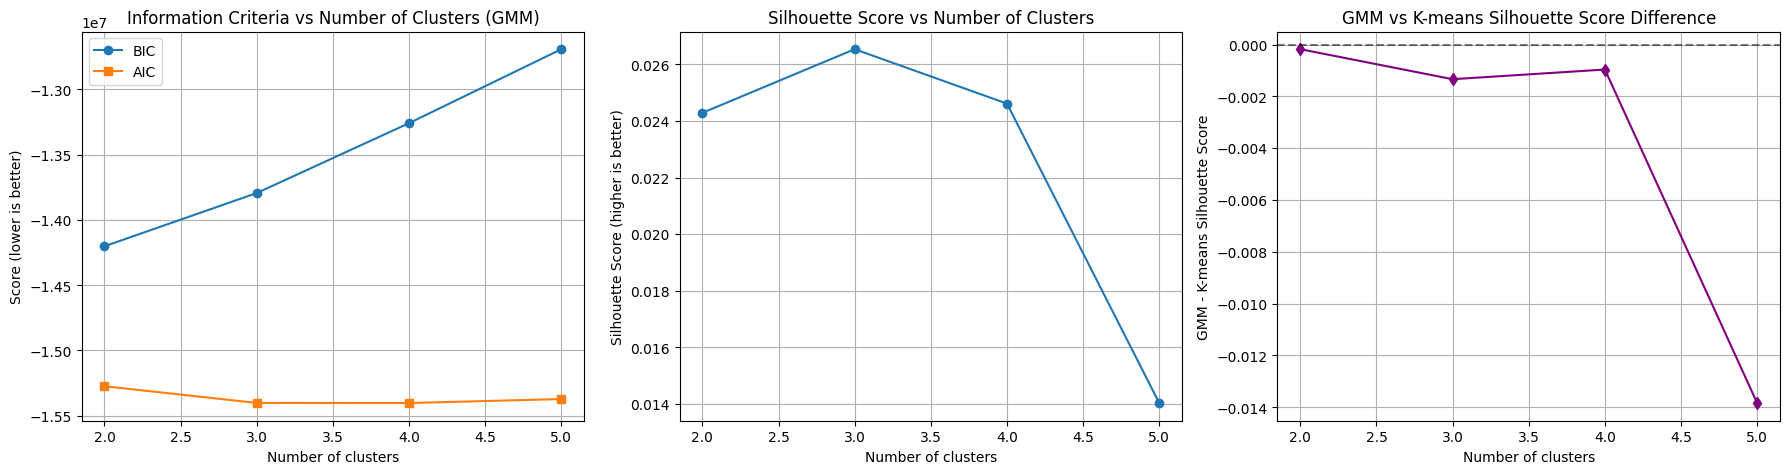

Best number of clusters for K-means (by silhouette): 3
Best number of clusters for GMM (by silhouette): 3
Best number of clusters for GMM (by BIC): 2
Best number of clusters for GMM (by AIC): 4
Performing K-means clustering with 3 clusters...
K-means Silhouette Score: 0.0279
Performing GMM clustering with 3 components...
GMM Silhouette Score: 0.0265
GMM BIC Score: -13794394.04
GMM AIC Score: -15401679.85
Reducing dimensions using PCA...


In [66]:


# Sample size 
SAMPLE_SIZE = 10000  # Adjust!

if len(train_df) > SAMPLE_SIZE:
    sample_df = train_df.sample(SAMPLE_SIZE, random_state=21)
else:
    sample_df = train_df.copy()

texts = sample_df['cleaned_sentence'].tolist()


embeddings = sentence_transformer_embeddings(texts)

best_kmeans_clusters, best_gmm_clusters = find_optimal_clusters(embeddings, max_clusters=5)


# K-means Clustering
kmeans_labels, kmeans_model = kmeans_clustering(embeddings, n_clusters=best_kmeans_clusters)

# GMM Clustering
gmm_labels, gmm_model = gmm_clustering(embeddings, n_components=best_gmm_clusters)

# Reduce dimensions for visualization
reduced_embeddings_pca = reduce_dimensions(embeddings, method='pca')



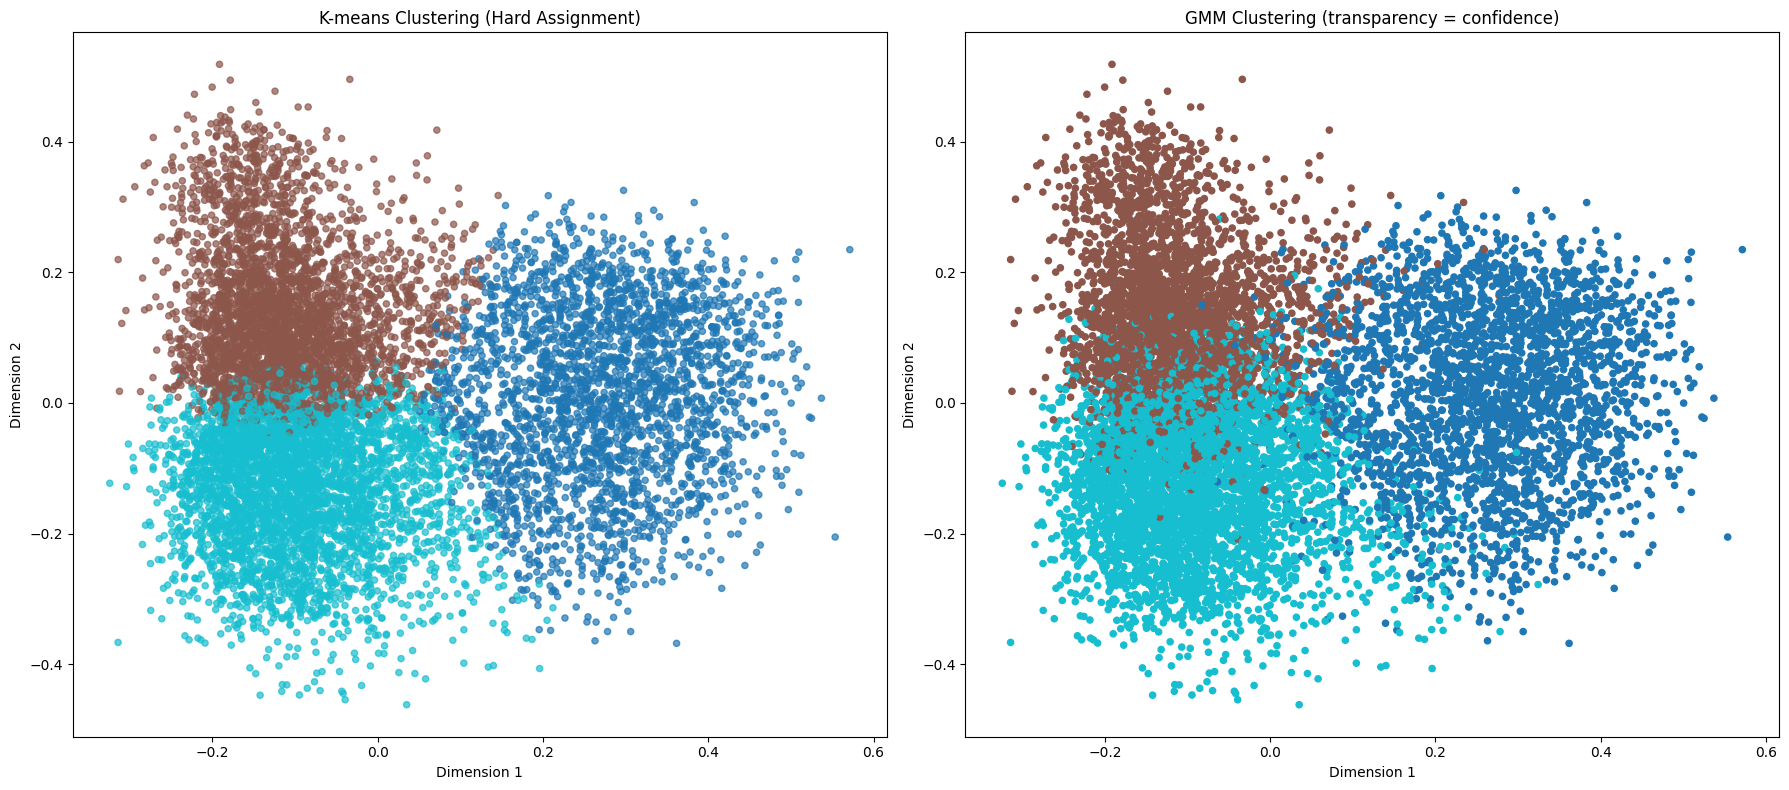

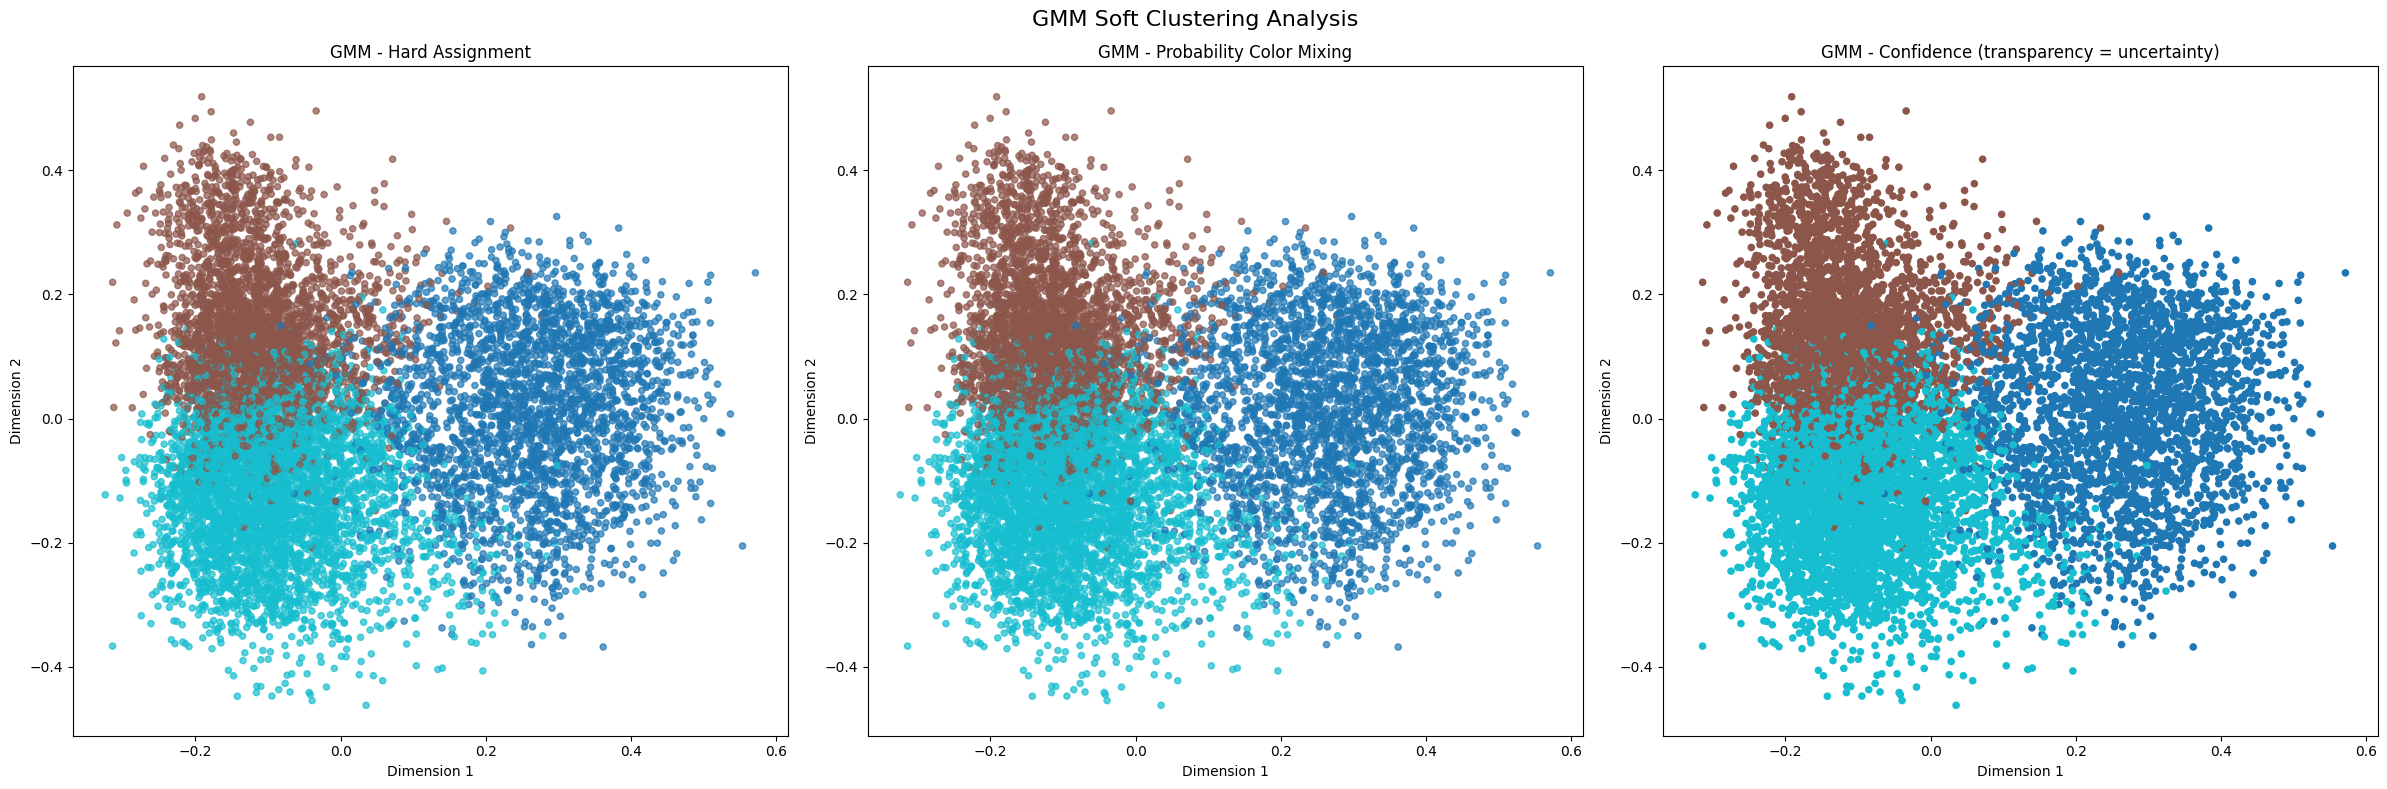


=== K-MEANS CLUSTERING RESULTS ===
Cluster 0 top words: food (398), ordered (181), like (170), restaurant (152), good (146), get (129), one (125), eat (123), chicken (118), place (116), menu (104), dinner (95), order (93), got (87), try (87)
Cluster 1 top words: like (162), one (141), movie (120), time (111), would (101), film (96), good (94), much (86), even (83), really (83), dont (82), get (78), place (77), know (75), never (69)
Cluster 2 top words: place (261), get (250), time (233), one (188), service (165), would (164), went (159), day (126), new (123), back (118), got (114), like (113), good (112), first (108), car (106)

=== GMM CLUSTERING RESULTS ===
Component 0 top words: food (381), ordered (182), like (172), good (143), get (133), restaurant (133), one (131), place (125), chicken (118), eat (118), menu (104), got (93), dinner (90), order (89), try (89)
Component 1 top words: like (149), one (128), movie (121), time (110), good (102), would (95), film (95), much (86), place

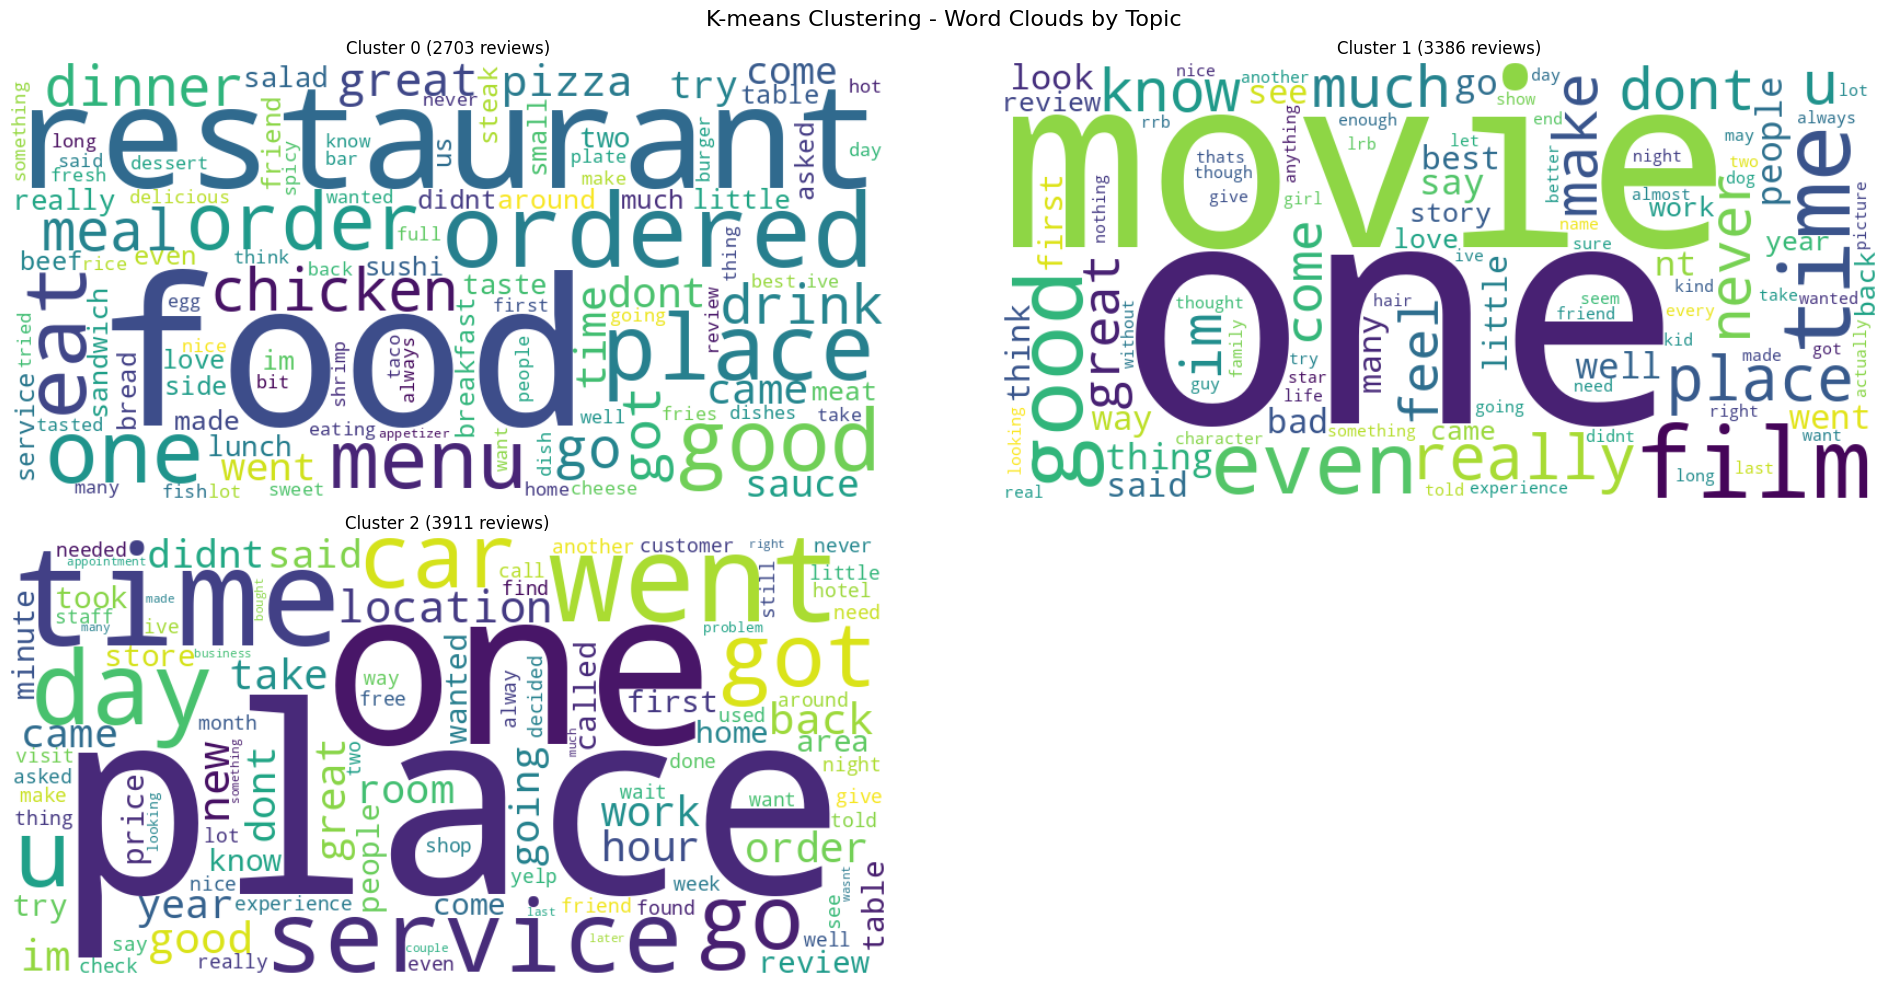

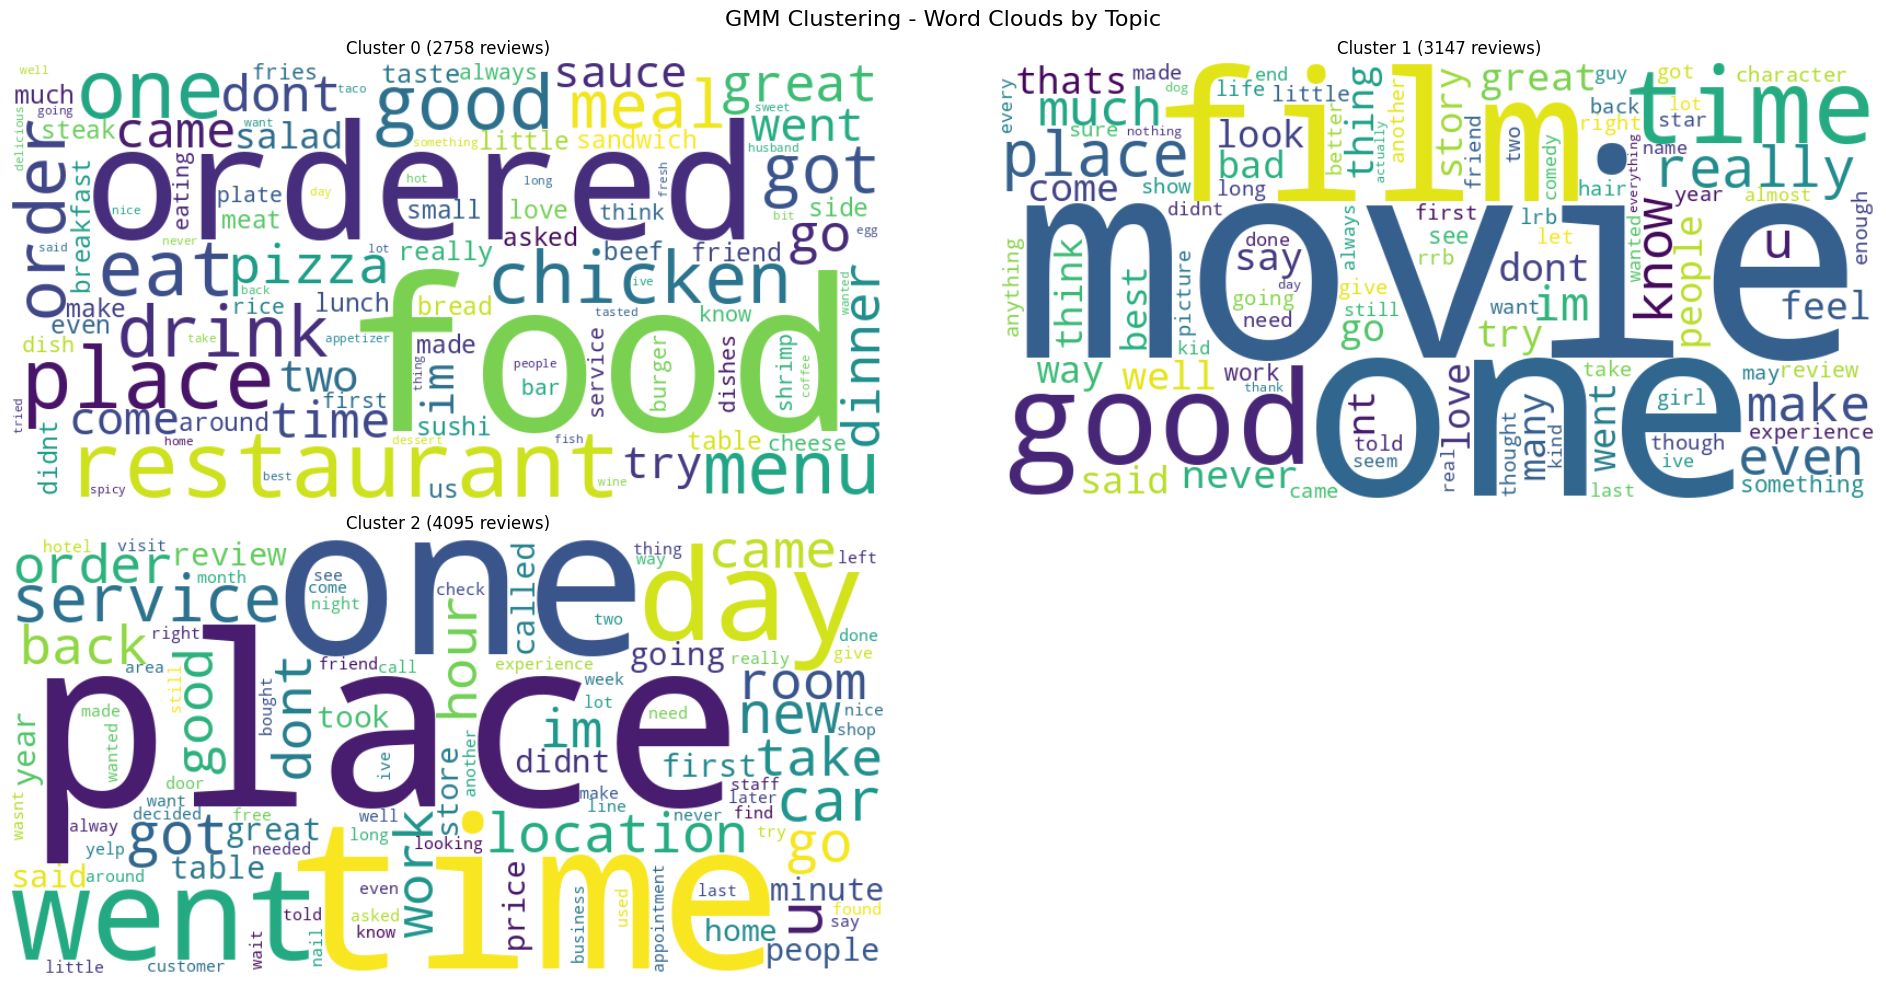

In [67]:
cluster_probabilities = gmm_model.predict_proba(embeddings)

compare_clusters(reduced_embeddings_pca, kmeans_labels, gmm_labels, cluster_probabilities)

plot_gmm_probabilities(reduced_embeddings_pca, cluster_probabilities, "GMM Soft Clustering Analysis")


# K-means clusters
print("\n=== K-MEANS CLUSTERING RESULTS ===")
kmeans_top_words = get_top_words_per_cluster(texts, kmeans_labels, best_kmeans_clusters, top_n=15)
for cluster, words in kmeans_top_words.items():
    print(f"Cluster {cluster} top words:", ", ".join([f"{word} ({count})" for word, count in words]))

# GMM clusters
print("\n=== GMM CLUSTERING RESULTS ===")
gmm_top_words = get_top_words_per_cluster(texts, gmm_labels, best_gmm_clusters, top_n=15)
for cluster, words in gmm_top_words.items():
    print(f"Component {cluster} top words:", ", ".join([f"{word} ({count})" for word, count in words]))

# Generate word clouds 
generate_wordclouds(texts, kmeans_labels, best_kmeans_clusters, title="K-means Clustering - Word Clouds by Topic")
generate_wordclouds(texts, gmm_labels, best_gmm_clusters, title="GMM Clustering - Word Clouds by Topic")

## Topic Modeling

In [69]:
from bertopic import BERTopic

hdbscan_clusterer = HDBSCAN(min_cluster_size = 30)

topic_model = BERTopic(hdbscan_model=hdbscan_clusterer)
topics, probs = topic_model.fit_transform(texts,embeddings)
topic_model.reduce_topics(texts, nr_topics=8)
topics = topic_model.topics_
topic_model.get_topic_info()

Topic  Count                          Name  \
0     -1   4025            -1_like_one_get_us   
1      0   2898        0_place_time_get_vegas   
2      1   1480  1_food_restaurant_menu_pizza   
3      2    790         2_movie_film_nt_story   
4      3    357   3_review_reviews_yelp_store   
5      4    302       4_hair_nails_nail_clean   
6      5     85            5_dog_vet_dogs_pet   
7      6     63             6_air_ac_hot_heat   

                                                              Representation  \
0              [like, one, get, us, time, would, ordered, place, food, good]   
1            [place, time, get, vegas, one, service, went, car, would, said]   
2      [food, restaurant, menu, pizza, eat, get, like, ordered, place, good]   
3                [movie, film, nt, story, lrb, rrb, comedy, like, one, much]   
4    [review, reviews, yelp, store, cash, price, read, write, prices, cheap]   
5        [hair, nails, nail, clean, cut, cleaning, salon, done, get, carpet]   
6        [dog, vet, dogs, pet, cat, animal, petsmart, please, chicago, pets]   
7  [air, ac, hot, heat, water, conditioning, filter, blowing, degrees, cold]   

                                                                                   Representative_Docs  
0  [dont think ever able italian food anywhere else place good, nice waiter told us try bbq chicken...  
1  [first time went place spent 3 1/2 hours, wait time 15 minutes last time went, service okay dont...  
2  [want great food great service?, go restaurant food star show, everyone food really good must ne...  
3  [recent argentine film son bride reminded us feel-good movie still show real heart time favor pr...  
4                                        [looked yelp reviews good, review store, first yelp review !]  
5  [im usually one get nails done figured, came hair done always wear explained exactly needed want...  
6  [one dog days, take dog, small dog owners like sister yorky make sure dog around bigger dogs ple...  
7  [arizona gets extremely hot know hot air blowing face unpleasant experience, 2001 t&c blowing ho...

In [70]:
sample_df['topic'] = topics
sample_df['label'] = sample_df['label'].astype(str) 


### Check for Distributions

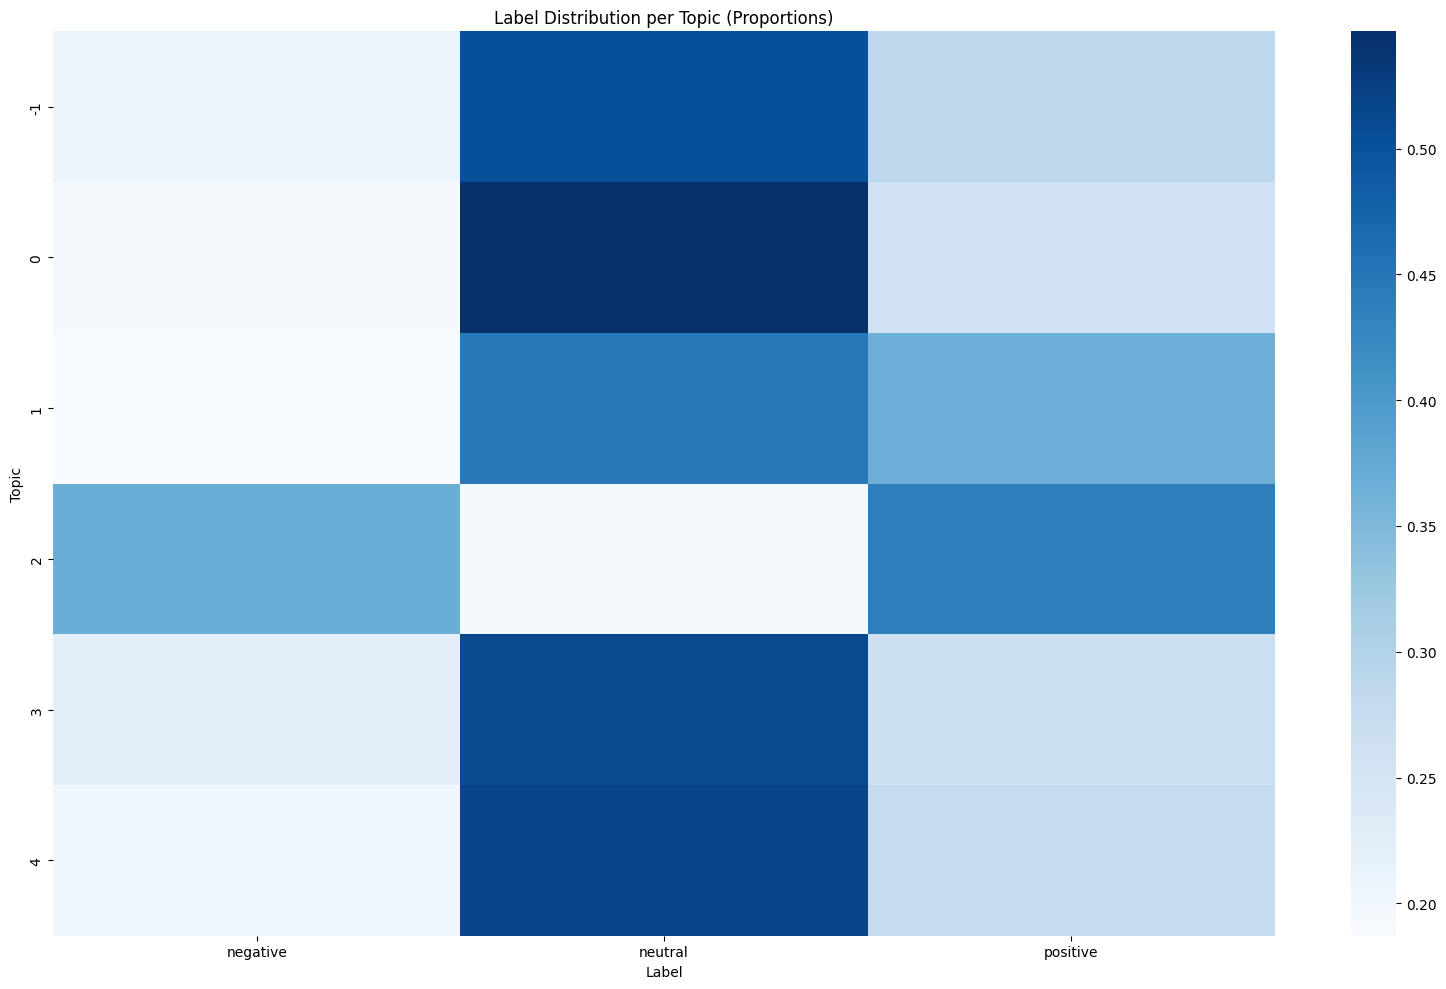

<Figure size 640x480 with 0 Axes>

In [71]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 10))

label_topic_counts = sample_df.groupby(['topic', 'label']).size().unstack(fill_value=0)

normalized = label_topic_counts.div(label_topic_counts.sum(axis=1), axis=0)

normalized_first_4_labels = normalized.iloc[:6, :]

sns.heatmap(normalized_first_4_labels, cmap="Blues", annot=False, cbar=True)

plt.title("Label Distribution per Topic (Proportions)")
plt.xlabel("Label")
plt.ylabel("Topic")
plt.tight_layout()
plt.show()
filename = "label_distribution_heatmap.png"
plt.savefig(filename, dpi=300, bbox_inches='tight') 


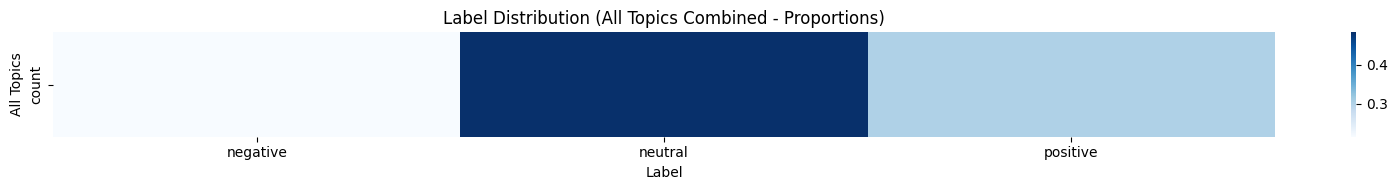

In [72]:
label_counts = sample_df['label'].value_counts()
label_counts_sorted = label_counts.sort_index()
label_proportions = label_counts_sorted / label_counts_sorted.sum()

heatmap_data = label_proportions.to_frame().T 


plt.figure(figsize=(16, 2))

sns.heatmap(heatmap_data, cmap="Blues", annot=False, fmt=".2f", cbar=True)

plt.title("Label Distribution (All Topics Combined - Proportions)")
plt.xlabel("Label")
plt.ylabel("All Topics") # Changed Y-axis label to reflect combined topics
plt.tight_layout()

filename = "label_distribution_heatmap_total.png"
plt.savefig(filename, dpi=300, bbox_inches='tight') 

In [ ]:
label_topic_counts = sample_df.groupby(['topic', 'label']).size().unstack(fill_value=0)

for topic in label_topic_counts.index:
    topic_dist = label_topic_counts.loc[topic]
    
    topic_words = topic_model.get_topic(topic)
    topic_name = ", ".join([word for word, _ in topic_words[:5]])

    topic_dist = label_topic_counts.loc[topic]
    topic_dist.plot(kind='bar')
    plt.title(f'Label Distribution for Topic {topic} {topic_name}')
    plt.xlabel('Label')
    plt.ylabel('Count')
    plt.tight_layout()
    plt.show()

In [ ]:
!pip install python-ternary

Visualizing distributions for Topics: ['1_food_restaurant_menu_pizza', '2_movie_film_nt_story', '5_dog_vet_dogs_pet']


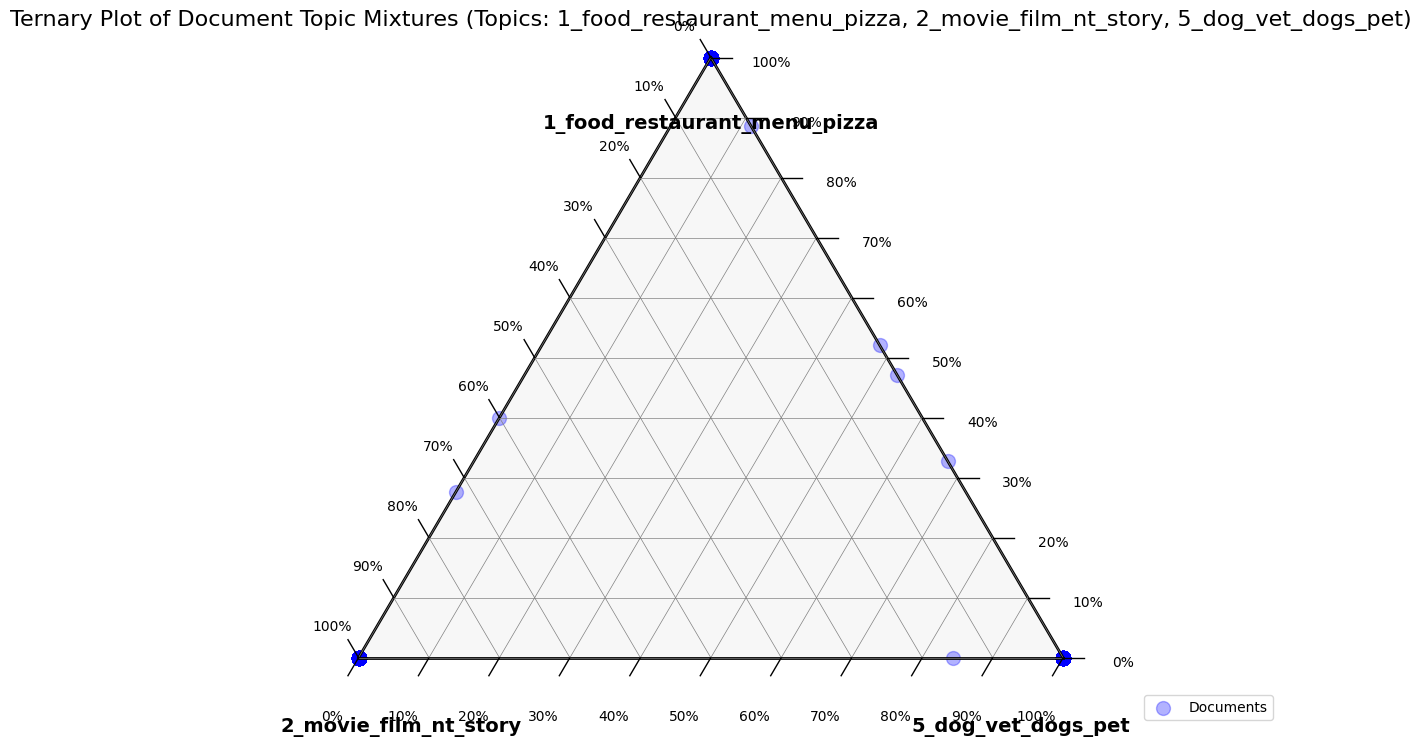

In [77]:
import ternary
topic_distr, _ = topic_model.approximate_distribution(texts)

topic_names = topic_model.get_topic_info()["Name"].tolist()
chosen_topic_indices = [2, 3, 6] 
chosen_topic_labels = [topic_names[idx] for idx in chosen_topic_indices]

print(f"Visualizing distributions for Topics: {chosen_topic_labels}")

selected_probs = topic_distr[:, chosen_topic_indices]

sums = np.sum(selected_probs, axis=1, keepdims=True)

sums[sums == 0] = 1 

normalized_selected_probs = selected_probs / sums

plot_data = normalized_selected_probs[sums.flatten() > 0.001] 


scale = 100 

fig, ax = plt.subplots(figsize=(10, 9))
ax.axis("off")
figure, tax = ternary.figure(ax=ax, scale=scale)

# Draw the boundary and gridlines
tax.boundary(linewidth=2.0)
tax.gridlines(multiple=scale/10, color="gray", linestyle='-')

ax.text(0.5, 0.87, chosen_topic_labels[0], transform=ax.transAxes, 
        ha='center', va='center', fontsize=14, weight='bold')
ax.text(0.1, 0, chosen_topic_labels[1], transform=ax.transAxes, 
        ha='center', va='center', fontsize=14, weight='bold')
ax.text(0.9, 0, chosen_topic_labels[2], transform=ax.transAxes, 
        ha='center', va='center', fontsize=14, weight='bold')

tax.ticks(axis='lbr', multiple=scale/10, linewidth=1, fontsize=10, offset=0.03, tick_formats="%d%%")

points = (plot_data * scale).tolist()

tax.scatter(points, marker='o', color='blue', s=100, alpha=0.3, label='Documents')
tax.legend(loc='lower left', bbox_to_anchor=(1.05, 0)) # Move legend outside plot
tax.set_title(f"Ternary Plot of Document Topic Mixtures (Topics: {chosen_topic_labels[0]}, {chosen_topic_labels[1]}, {chosen_topic_labels[2]})", fontsize=16)
tax.show()